In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [126]:
#train_df = pd.read_csv('titanic/train.csv')
# test_df = pd.read_csv('titanic/test.csv')
# train_df.info()

In [127]:
titanic = pd.read_csv('titanic/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [128]:
titanic.shape

(891, 12)

In [129]:
data = titanic[titanic.columns.difference(['Survived'])]
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,373450


In [130]:
target =titanic['Survived']

In [131]:
train_input, test_input, train_target, test_target = train_test_split(
    data, target, random_state=42)
train_input.shape, train_target.shape, test_input.shape,test_target.shape

((668, 11), (668,), (223, 11), (223,))

In [132]:
test_df = test_input.copy()

In [133]:
test_df['Survived'] = test_target
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Survived
709,NaN,NaN,C,15.2458,"Moubarek, Master. Halim Gonios (""William George"")",1,710,3,male,1,2661,1
439,31.0,NaN,S,10.5000,"Kvillner, Mr. Johan Henrik Johannesson",0,440,2,male,0,C.A. 18723,0
840,20.0,NaN,S,7.9250,"Alhomaki, Mr. Ilmari Rudolf",0,841,3,male,0,SOTON/O2 3101287,0
720,6.0,NaN,S,33.0000,"Harper, Miss. Annie Jessie ""Nina""",1,721,2,female,0,248727,1
39,14.0,NaN,C,11.2417,"Nicola-Yarred, Miss. Jamila",0,40,3,female,1,2651,1


In [134]:
train_df = train_input.copy()
train_df['Survived'] = train_target
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Survived
298,NaN,C106,S,30.5000,"Saalfeld, Mr. Adolphe",0,299,1,male,0,19988,1
884,25.00,NaN,S,7.0500,"Sutehall, Mr. Henry Jr",0,885,3,male,0,SOTON/OQ 392076,0
247,24.00,NaN,S,14.5000,"Hamalainen, Mrs. William (Anna)",2,248,2,female,0,250649,1
478,22.00,NaN,S,7.5208,"Karlsson, Mr. Nils August",0,479,3,male,0,350060,0
305,0.92,C22 C26,S,151.5500,"Allison, Master. Hudson Trevor",2,306,1,male,1,113781,1


In [135]:
train_df.shape, test_df.shape

((668, 12), (223, 12))

In [136]:
# Not sure passenger ID is useful as a feature, but need to save it from the test set for the submission
test_passenger_ids = test_df.pop('PassengerId')
train_df.drop(['PassengerId'], axis=1, inplace=True)

# 'Embarked' is stored as letters, so fit a label encoder to the train set to use in the loop
embarked_encoder = LabelEncoder()
embarked_encoder.fit(train_df['Embarked'].fillna('Null'))

# Dataframes to work on
df_list = [train_df, test_df]

for df in df_list:    
    
    # Record anyone travelling alone
    df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)
    
    # Transform 'Embarked'
    df['Embarked'].fillna('Null', inplace=True)
    df['Embarked'] = embarked_encoder.transform(df['Embarked'])
    
    # Transform 'Sex'
    df.loc[df['Sex'] == 'female','Sex'] = 0
    df.loc[df['Sex'] == 'male','Sex'] = 1
    df['Sex'] = df['Sex'].astype('int8')
    
    # Drop features that seem unusable. Save passenger ids if test
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [137]:
# Separate the label
y = train_df.pop('Survived')

# Take a hold out set randomly
X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass', 'Embarked']
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgbm.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)

In [138]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
              }

In [139]:
evaluation_results = {}
clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

[LightGBM] [Info] Number of positive: 188, number of negative: 313
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 501, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375250 -> initscore=-0.509761
[LightGBM] [Info] Start training from score -0.509761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	Train's binary_logloss: 0.26918	Test's binary_logloss: 0.446456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	Train's binary_logloss: 0.226196	Test's binary_logloss: 0.462546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

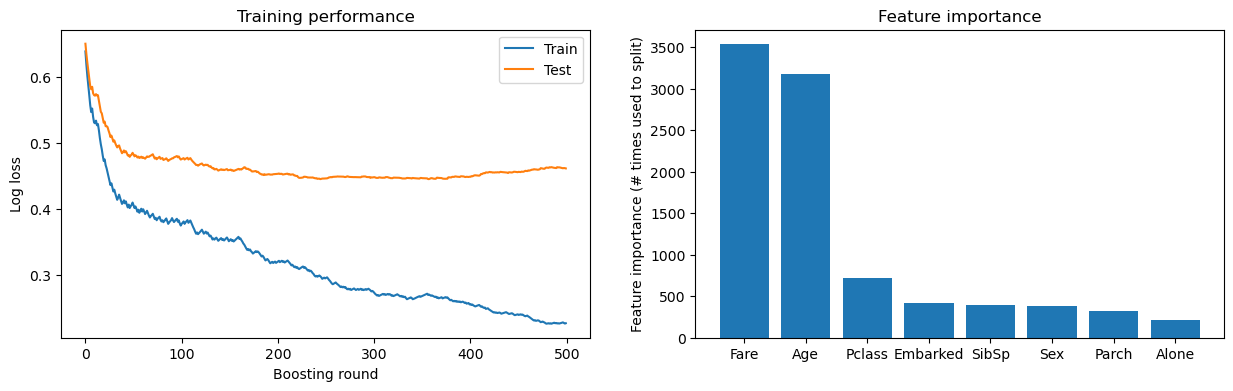

In [140]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [141]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))

Accuracy score = 	 0.7964071856287425
